## Descrição do trabalho
Este notebook realiza um experimento preliminar de contruir um modelo preditivo de regressão para valores de medicamentos a partir de uma base de dados que contém receitas médicas para medicamentos manipulados.
Os campos da base de dados original são:
- descricao - contém uma relação de principios ativos, dosagens e quantificações de dosagens, quantidade e descrição das formas farmacêuticas de medicamentos incluídos na formulação
- criado - tem a data/hora da criação da receita, possivelmente quando ela entrou no sistema da farmácia
- qtdInsumos - contém o número de insumos (chamados neste trabalho de princípio ativo) constantes na formulação prescrita e descrita na descrição
- calculado - contém o valor calculado (não sabemos se automaticamente no cadastro ou pela atendente que cadastrou)
- correto - contém o valor correto da medicação

Ao longo do notebook o experimento será descrito


In [38]:
%pip install shap
%pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [1]:
# realizamos a importação das bibliotecas python a serem utilizadas
import hashlib 

import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor


c:\Users\F13818D\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\F13818D\AppData\Local\Temp\ipykernel_23916\2684150147.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#carregamos o dataframe com as informações das receitas
df = pd.read_csv('C:\git_desafio\desafio-machine-learning\dados_preco.csv',sep=',')

### Tratamento Especial aos princípios ativos
Foi realizada uma análise exploratória preliminar no dataset candidato utilizando a ferramenta PowerBI. Esta análise se encontra em pdf no diretório deste projeto, bem como o arquivo pbix para ser aberto. Como não há certeza das versões de PowerBi pelo leitor, a análise também foi gerada em PDF.
Observou-se que o campo descrição continha alguns desafios comuns de mineração de textos e PNL. As ações para resolver esses desafios são tomadas a partir deste ponto do notebook.


In [3]:
# criação de uma função para transformar a lista de principios ativos na descrição em um dicionario iterável em python,
# separando principio ativo e dosagens das quantidades e formas farmacêuticas
def parse_description(description):
    quantity, items = description.split("|")
    quantity = quantity.strip()
    items_list = [item.strip() for item in items.split(";")]
    items_dict = {str(i+1): item for i, item in enumerate(items_list)}
    return quantity, items_dict

# Exemplo de uso
description = "60 CAP | NAC  250MG; SILIMARINA  150MG; SAME  50MG"
quantidade, itens = parse_description(description)
print("Quantidade:", quantidade)
print("Itens:", itens)



Quantidade: 60 CAP
Itens: {'1': 'NAC  250MG', '2': 'SILIMARINA  150MG', '3': 'SAME  50MG'}


In [4]:
#adicionando ao Dataframe colunas separadas para principios ativos e quantidades 
df[['quantidade', 'itens']] = df['descricao'].apply(lambda x: pd.Series(parse_description(x)))

In [5]:
#criação de uma função para gerar um hash de identificação unitária para a receita, o que 
#será util ao longo de todo o experimento
def generate_hash(description):
    return hashlib.md5(description.encode()).hexdigest()



In [6]:
# Adicionando a coluna de hash ao dataframe
df['hash'] = df['descricao'].apply(generate_hash)

### Processamento de Linguagem Natural
O campo descrição da receita pode conter uma informação que consideramos muito valiosa, porque hipoteticamente, o fator determinante para o preço de um medicamento são os princípios ativos que estes contém.
Pelo motivo acima decidimos aprofundar ao máximo no tratamento do campo descrição. 

In [7]:
# copiando o primeiro DataFrame de forma preventiva (todas as antigas colunas, igual ao original)
df_original = df

# Criando o segundo DataFrame (apenas a coluna 'itens', expandida), mantendo o hash para não 
# perder o link com a receita que originou os itens
item_rows = []
for _, row in df.iterrows():
    for key, value in row['itens'].items():
        item_rows.append({'hash': row['hash'], 'num_item': key, 'descricao_item': value})

df_itens = pd.DataFrame(item_rows)



In [8]:
# separação do dataframe de itens do texto do principio ativo e da dosagem, de forma que o texto possa ser 
# tratado especialmente
df_itens[['principio_ativo', 'dosagem']] = df_itens['descricao_item'].apply(lambda x: pd.Series([ ' '.join(x.split()[:-1]), x.split()[-1] ]))
df_itens['principio_ativo'] = df_itens['principio_ativo'].str.replace(',', '.')


In [9]:
# visualizando o dataframe de itens
display(HTML(df_itens.head(10).to_html()))

#### Limpeza nos princípios ativos
Os princípios ativos serão então isolados em um dataframe separado, onde seus nomes serão deduplicados, e assim este dataframe será
submetido a um LLM para que se criem clusters de medicamentos. Conforme o leitor pode ver na Análise Exploratória em PowerBi, são 1632 princípios ativos descritos, que tem pequenas variações em linguagem natural que precisam ser corrigidas para um bom trabalho.

In [ ]:
#criação de um dataframe de princípios ativos
df_principios_ativos = df_itens[['principio_ativo']].copy()

#Agrupamento para contar quantos principios ativos iguais existem
df_principios_ativos['quantidade'] = df_principios_ativos.groupby('principio_ativo')['principio_ativo'].transform('size')

# Remover duplicatas
df_principios_ativos = df_principios_ativos.drop_duplicates(subset='principio_ativo').reset_index(drop=True)
# Orderar alfabeticamente
df_principios_ativos = df_principios_ativos.sort_values(by='principio_ativo').reset_index(drop=True)

#salvamento dos principios ativos para processamento do LLM
df_principios_ativos.to_excel('principios_ativos.xlsx')


#### Utilização de LLM para clusterização dos princípios ativos
A clusterização de textos por similaridade não é uma funcionalidade nova, muito menos advinda dos LLMs, porém a título de demonstração optamos por utilizar a API da OpenAI com um prompt criado especificamente após a observaçao pela análise exploratória dos eventos mais comuns de diferença nas descrições armazenadas. O arquivo em principios_ativos.xlsx foi trabalho separadamente em um outro notebook também anexado neste trabalho. O nome deste notebook é llm_call_v2.

In [11]:
#recuperação do cluster de medicamentos

cluster_medicamentos = pd.read_excel('clusters.xlsx')

In [12]:
#colunas retornadas no cluster medicamentos
cluster_medicamentos.columns

Index(['Unnamed: 0', 'original', 'cluster'], dtype='object')

In [13]:

# Adição do nome do cluster ao dataframe de itens
df_itens = df_itens.merge(cluster_medicamentos[['original', 'cluster']], left_on='principio_ativo', right_on='original', how='left')



In [14]:
# Neste ponto estamos extraindo do item a unidade e a dosagem para ter a informação separada
df_itens['dose'] = df_itens['dosagem'].str.extract(r'(\d+[\.,]?\d*)')  # Extrai a parte numérica
df_itens['unidade'] = df_itens['dosagem'].str.extract(r'([a-zA-Z]+)')  # Extrai a parte textual (unidade de medida)


In [15]:
# Salvamento do dataframe finalizado para análise exploratória no Power BI
df_itens.to_excel('itens_finalizados.xlsx')

In [16]:
#avaliação das colunas do dataframe
df_itens.columns

Index(['hash', 'num_item', 'descricao_item', 'principio_ativo', 'dosagem',
       'original', 'cluster', 'dose', 'unidade'],
      dtype='object')

In [17]:
#simplificando o dataframe a titulo de facilitar 
df_itens_selecionado = df_itens[['hash', 'cluster', 'dose', 'unidade']]

## Enconding
Por se tratar de um caso de regressão, precisamos encontrar uma forma harmônica de representar os principios ativos e suas dosagens de maneira a conseguir transformar os mesmos, que são categóricos, em valores numéricos.
A execução da clusterização já foi feita com o objetivo de obviamente deduplicar, mas também simplificar e reduzir o número de categorias para realizar o encoding. Como pode ser visto na Análise Exploratória, reduzimos os princípios ativos de 1632 descrições para 940 clusters.<br>
Vários encoders são candidatos para serem usados neste momento. A título de tempo disponível utilizaremos uma abordagem onde a dose e a unidade serão embutidas no encoder.<br>
ATENÇÃO: o processo de encoder precisa ser pensado com muitíssimo cuidado. Neste experimento simplesmente implementamos a abordagem mais rápida possível devido ao tempo disponível para implementar e entregar. Muitas melhorias podem ser feitas neste processo, e seria de grande valor uma conversa 1:1 com o leitor para explicar melhor os prós, contras, riscos e mitigações deste enconder executado.
Enfim, neste caso o bom seria inimigo do ótimo, então seguimos em frente com foco na entrega de um MVP.

In [18]:
#geracão de uma sigla com o nome do principio ativo tratando duplicados para simplificar o nome da coluna do encoder
siglas = {}
def gerar_sigla(cluster):
    partes = cluster.split()
    sigla = ''.join([p[:3].upper() for p in partes])  # Usa 3 primeiras letras de cada palavra
    original_sigla = sigla
    contador = 1
    while sigla in siglas:  # Se já existe, adiciona um número incremental
        sigla = original_sigla + str(contador)
        contador += 1
    siglas[sigla] = cluster
    return sigla
#criação da sigla no dataframe

df_itens_selecionado['cluster_sigla'] = df_itens_selecionado['cluster'].apply(gerar_sigla)

#criação de um campo que será chave no encoder com a sigla+dose+unidade
df_itens_selecionado['key'] = df_itens_selecionado['cluster_sigla'] + '_' + df_itens_selecionado['dose'].astype(str) + '_' + df_itens_selecionado['unidade']
# Aplicar OneHotEncoder na chave reduzida
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_values = one_hot_encoder.fit_transform(df_itens_selecionado[['key']])

# Criar um DataFrame com as variáveis codificadas e nomes reduzidos
encoded_columns = one_hot_encoder.get_feature_names_out(['key'])
encoded_columns = [col.replace('key_', '') for col in encoded_columns]  # Remover prefixo desnecessário

df_encoded = pd.DataFrame(encoded_values, columns=encoded_columns)

# Concatenar os dados codificados ao DataFrame original
df_itens_selecionado_encoded = pd.concat([df_itens_selecionado[['hash']], df_encoded], axis=1)

# Agregar por 'hash' e usar 'max' para manter a presença dos valores
df_aggregated = df_itens_selecionado_encoded.groupby('hash').agg('max').reset_index()

# Exibir o resultado final
print(df_aggregated)


C:\Users\F13818D\AppData\Local\Temp\ipykernel_23916\3758063925.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_itens_selecionado['cluster_sigla'] = df_itens_selecionado['cluster'].apply(gerar_sigla)
C:\Users\F13818D\AppData\Local\Temp\ipykernel_23916\3758063925.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_itens_selecionado['key'] = df_itens_selecionado['cluster_sigla'] + '_' + df_itens_selecionado['dose'].astype(str) + '_' + df_itens_selecionado['unidade']


                                  hash  17BETESTBAS1_1_MG  17BETESTBAS_1_MG   
0     00134ceefa0d6a5e72b265b78f3e1772                0.0               0.0  \
1     001cbb4ae9437443a7f89f75c3f52be1                0.0               0.0   
2     0024aa415003eddb2ce0604cf7cbc131                0.0               0.0   
3     00255614aa12f2f5df9648f70e6e7ed6                0.0               0.0   
4     00316f7dd7c827126569eca9b52391a6                0.0               0.0   
...                                ...                ...               ...   
7116  ffe8f7e718f43a31981ada15c94c6b7c                0.0               0.0   
7117  ffef9472b60e72f5b9b1688392d7498f                0.0               0.0   
7118  fff0795b458c2b124a321037a5d0b68c                0.0               0.0   
7119  fff0e1365e652b9d5e45cd23d9dee914                0.0               0.0   
7120  fff385e35da022c52c94b4bedad8405c                0.0               0.0   

      25(D3_10000_UI  25HIDD_800_UI  5HTP100_50_MG 

In [19]:
display(HTML(df_aggregated.head(10).to_html()))

#### Redução de Dimensionalidade
Conforme pode ser visto acima, a combinatória de principio ativo (em cluster), dosagem e unidade gerou um encoder com 23355 colunas. Como prática neste campo da análise de regressão, precisamos executar uma redução de dimensionalidade para termos um dataset de treinamento, teste e validação viável para executar o experimento. 
Tentamos então duas técnicas para escolher o melhor resultado:
- Análise de Componentes Principais (PCA)
- Truncated Singular Value Decomposition (TruncatedSVD)


In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler


X = df_aggregated.drop(columns=['hash'])  # Remover a coluna 'hash' antes da redução

# Normalizar os dados antes do PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduzindo para 50 componentes principais com Truncated SVD
svd = TruncatedSVD(n_components=50, random_state=42)
X_svd = svd.fit_transform(X_scaled)

# Testando PCA para comparação
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Criar DataFrames com os componentes reduzidos
df_svd = pd.DataFrame(X_svd, columns=[f'comp_{i+1}' for i in range(50)])
df_pca = pd.DataFrame(X_pca, columns=[f'pca_{i+1}' for i in range(50)])

# Adicionar a coluna 'hash' de volta para identificação
df_svd.insert(0, 'hash', df_aggregated['hash'])
df_pca.insert(0, 'hash', df_aggregated['hash'])


Variância explicada pelos 50 componentes:
Truncated SVD: 3.79%
PCA: 3.86%


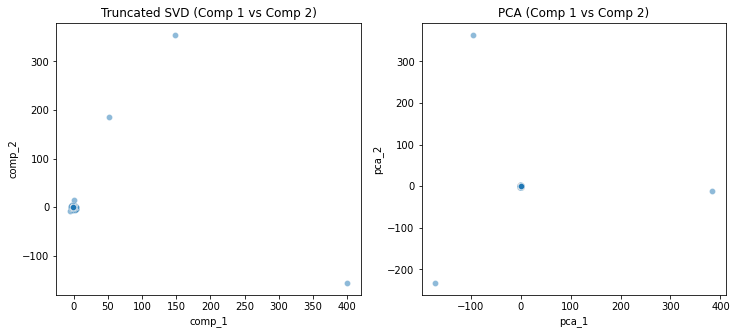

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comparar a variância explicada
var_svd = np.sum(svd.explained_variance_ratio_)
var_pca = np.sum(pca.explained_variance_ratio_)

print(f"Variância explicada pelos 50 componentes:")
print(f"Truncated SVD: {var_svd:.2%}")
print(f"PCA: {var_pca:.2%}")

# Plotando os componentes principais dos dois métodos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x=df_svd['comp_1'], y=df_svd['comp_2'], alpha=0.5, ax=axes[0])
axes[0].set_title("Truncated SVD (Comp 1 vs Comp 2)")

sns.scatterplot(x=df_pca['pca_1'], y=df_pca['pca_2'], alpha=0.5, ax=axes[1])
axes[1].set_title("PCA (Comp 1 vs Comp 2)")

plt.show()


##### Vamos prosseguir o trabalho utilizando o PCA, simplesmente pela variancia semelhante e preferência pessoal pela técnica

### Transformando a quantidade de cápsulas em texto para números
Vamos agora em passos finais, isolar a quantidade de cápsulas em uma coluna para aproveitar este valor como um dos inputs no modelo.

In [22]:
# Extrai apenas os números (inclui inteiros e decimais)
df_original['quantidade_prescrita'] = df_original['quantidade'].str.extract(r'(\d+\.?\d*)')

# Converte para número (float ou int) se necessário
df_original['quantidade_prescrita'] = pd.to_numeric(df_original['quantidade_prescrita'])


In [23]:
df_original.columns

Index(['descricao', 'criado', 'qtdInsumos', 'calculado', 'correto',
       'quantidade', 'itens', 'hash', 'quantidade_prescrita'],
      dtype='object')

### Ultimos tratamentos para construi o dataset para processamento

In [24]:
# Juntando o dataframe original com o dataframe representativo em PCA dos principios ativos
df_final = pd.merge(df_original, df_pca, on='hash', how='inner')


In [25]:
# Transformando a data "criado" em unix timestamp numérico
df_final['criado'] = pd.to_datetime(df_final['criado'])

# Converte para timestamp em milissegundos
df_final['criado'] = df_final['criado'].astype('int64') // 10**6


In [26]:
#retirando do dataframe campos que não são numéricos
df_final = df_final.drop(['descricao', 'quantidade', 'itens'], axis=1)

In [27]:
#Verificando as colunas finais
df_final.columns

Index(['criado', 'qtdInsumos', 'calculado', 'correto', 'hash',
       'quantidade_prescrita', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5',
       'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12',
       'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19',
       'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26',
       'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33',
       'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40',
       'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47',
       'pca_48', 'pca_49', 'pca_50'],
      dtype='object')

In [28]:
#verificando a integridade do dataframe final com o dataframe inicial
len(df_final) == len(df)

True

In [29]:
#verificando se todos os tipos estão de acordo
print(df_final.dtypes)

criado                    int64
qtdInsumos                int64
calculado               float64
correto                 float64
hash                     object
quantidade_prescrita      int64
pca_1                   float64
pca_2                   float64
pca_3                   float64
pca_4                   float64
pca_5                   float64
pca_6                   float64
pca_7                   float64
pca_8                   float64
pca_9                   float64
pca_10                  float64
pca_11                  float64
pca_12                  float64
pca_13                  float64
pca_14                  float64
pca_15                  float64
pca_16                  float64
pca_17                  float64
pca_18                  float64
pca_19                  float64
pca_20                  float64
pca_21                  float64
pca_22                  float64
pca_23                  float64
pca_24                  float64
pca_25                  float64
pca_26  

### Treinamento
Posto que atingimos um dataset com número de parâmetros de acordo para o treinamento de um modelo de regressão, vamos seguir o experimento proponto três modelos distintos para escolher, em teste, qual deles tem a melhor performance.

In [30]:
#criando um dataset em separado para treinamento
df_receitas = df_final

#### Train Test Split
Com retirada antecipada de 2000 elementos aleatórios para validação posterior

In [31]:
# Passo 1: Separar as 2000 linhas para validação conforme orientado 
df_receitas_validation = df_receitas.sample(n=2000, random_state=42)

# O restante do dataset será usado para treinamento e teste
df_receitas_train_test = df_receitas.drop(df_receitas_validation.index)

# Passo 2: Divisão entre treino e teste (80% treino, 20% teste)
X = df_receitas_train_test.drop(columns=['correto', 'hash'])
y = df_receitas_train_test['correto']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Normalização

In [32]:
# Passo 3: Pré-processamento - Normalização dos dados numéricos
scaler = StandardScaler()

# Normalizando os dados de treino e teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Árvore de Descisão

In [33]:
# Modelo 1: Árvore de Decisão
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train_scaled, y_train)

# Avaliação do modelo - Árvore de Decisão
y_pred_tree = tree_model.predict(X_test_scaled)
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
mae_tree = mean_absolute_error(y_test, y_pred_tree)
print(f"Árvore de Decisão - RMSE: {rmse_tree:.4f}, MAE: {mae_tree:.4f}")

Árvore de Decisão - RMSE: 64.0937, MAE: 17.8682


##### Random Forest

In [34]:
# Modelo 2: Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Avaliação do modelo - Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest - RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}")



Random Forest - RMSE: 58.2132, MAE: 13.8896


##### XGBoost

In [35]:

# Modelo 3: XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Avaliação do modelo - XGBoost
y_pred_xgb = xgb_model.predict(X_test_scaled)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost - RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}")

XGBoost - RMSE: 61.1712, MAE: 15.5314


#### Avaliação das Features pela biblioteca Shap
O grafico abaixo mostra vários pontos de melhoria para incrementar o resultado deste experimento, que deixaremos aqui como sugestões para abordagens futuras:
- Remover outliers na coluna insumos.
- Remover a coluna calculado.
- Utilizar outras abordagens de encoder para que tenhamos uma PCA mais importante na predição.


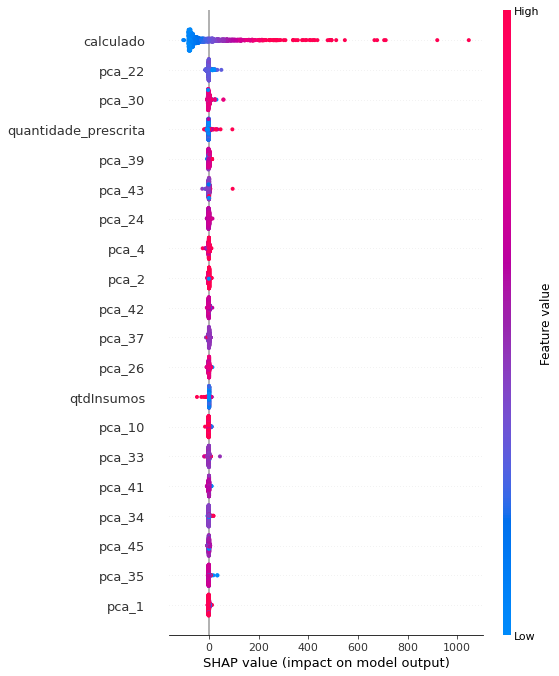

In [36]:
# Explicabilidade com SHAP (Random Forest)
explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Visualizando o gráfico de importância das variáveis
shap.summary_plot(shap_values, X_test)

# Passo 9: Usando o modelo Random Forest para prever no conjunto de validação
X_validation = df_receitas_validation.drop(columns=['correto', 'hash'])
X_validation_scaled = scaler.transform(X_validation)

y_validation_pred = rf_model.predict(X_validation_scaled)

# Visualizando as predições para o conjunto de validação
df_receitas_validation['predito'] = y_validation_pred

# Se desejar salvar as predições para análises futuras
df_receitas_validation[['hash', 'correto', 'predito']].to_csv('predicoes_validacao.csv', index=False)

#### Otimização de Hiperparâmetros
Não poderiamos encerrar o experimento sem tentar averiguar se uma otimização poderia ser feita para que o modelo Random Forest apresentasse maior eficiência. 

In [37]:
# Importando as bibliotecas necessárias
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definindo os hiperparâmetros para ajustar
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras para ser uma folha
    'max_features': ['auto', 'sqrt', 'log2'],  # Número de características a considerar para cada divisão
    'bootstrap': [True, False]  # Usar ou não amostragem com reposição
}

# Criando o modelo RandomForest
rf_model = RandomForestRegressor(random_state=42)

# Realizando a busca em grade (GridSearchCV)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5,  # Validação cruzada de 5 partes
                           n_jobs=-1,  # Usar todos os núcleos disponíveis
                           verbose=2,  # Para visualizar o progresso
                           scoring='neg_mean_squared_error')  # Usamos MSE negativo porque o GridSearch busca maximizar a pontuação

# Treinando o modelo com GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Treinando o modelo com os melhores parâmetros encontrados
best_rf_model = grid_search.best_estimator_

# Avaliando o modelo no conjunto de teste
y_pred_best_rf = best_rf_model.predict(X_test_scaled)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)

print(f"Melhor Random Forest - RMSE: {rmse_best_rf:.4f}, MAE: {mae_best_rf:.4f}")


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


c:\Users\F13818D\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Melhores parâmetros: {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Melhor Random Forest - RMSE: 57.6121, MAE: 13.2793


#### Resultado da otimização
Não cremos que a otimização possa trazer resultados muito diferentes, então finalizamos o experimento.
O arquivo Power BI de análise exploratória descreve o comportamento dos dados de validação.